In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import string
from string import punctuation
from os import listdir
from collections import Counter
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from pandas import DataFrame
from matplotlib import pyplot as plt

**Overview**

A script that fetches the first page of top critics' reviews for any movie on Rotten Tomatoes, and then applies Sentiment Analysis on each review to calculate a positivity Score for it. The movie name and year of its release are necessary parameters that are specified by the user.

The Bag of Words model is used to calculate a positivity score for each movie review. To create this model, a dataset of 2000 IMDB movie reviews (1000 positive and 1000 negative) made by Bo Pang and Lillian Lee is used. From this, a vocabulary is created, based on which the movie reviews are judged by the model. The positivity scores for each review are then calculated and visualized.

**Web Scraping the Movie Reviews from Rotten Tomatoes**

In [2]:
def get_reviews(page_url):
    response = requests.get(page_url)
    
    if not response.ok:
        print("Movie not found")
        return
    
    source = response.text
    soup = BeautifulSoup(source, "html.parser")
    review_containers = soup.find_all("div", class_ = "review-row")
    
    names = []     
    sources = []     
    contents = []     
    dates = []     
    scores = []      
    
    for container in review_containers:        
        name = container.find("a", class_="display-name").text.strip()    
        names.append(name)  
        
        source = container.find("a", class_="publication").text.strip()        
        sources.append(source) 
        
        content = container.find("p", class_="review-text").text.strip()         
        contents.append(content)   
        
        date = container.find("p", class_="original-score-and-url").text.replace("Full Review", "")
        date = re.sub("| Original Score: ./10", "", date).strip()
        date = re.sub("| Original Score: ./.", "", date).strip()
        date = re.sub("| Original Score: .\../.", "", date).strip()
        date = re.sub("| Original Score: [A-Z][+-]", "", date).strip()
        date = re.sub("| Original Score: [A-Z]", "", date).strip()

        date = date.replace("|", "").strip()        
        dates.append(date)
        
        temp = container.find("p", class_="original-score-and-url")
        score = re.search(".\../.", temp.text)
        
        if score: 
            score = score.group(0)
        else:             
            score = re.search("./10", temp.text)  
            
            if score:
                score = score.group(0)
            else: 
                score = re.search("./.", temp.text)  
            
                if score:
                    score = score.group(0)
                else: 
                    if score:
                        score = score.group(0)
                    else:
                        score = re.search("[A-Z]\+", temp.text)
                
                        if score:
                            score = score.group(0)
                
                        else:
                            score = re.search("[A-Z]-", temp.text)
                    
                            if score:
                                score = score.group(0)
                            else:
                                score = re.search("Original Score: [A-Z]", temp.text)
                        
                                if score:
                                    score = score.group(0).replace("Original Score: ", "").strip()
                                else:
                                    score = 'None'
        
        scores.append(score)

      
    reviews = pd.DataFrame({'name': names, 'source': sources, 'content': contents, 'score': scores, 'date': dates})    
    
    return reviews  

**Create Vocab File from Movie Review Dataset**

In [3]:
def load_doc(filen):
 # open the file as read only
    file = open(filen, 'r')
 # read all text
    text = file.read()
 # close the file
    file.close()
    
    return text
 
# turn a doc into clean tokens
def clean_doc(doc):
 # split into tokens by white space
    tokens = doc.split()
 # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]

 # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
 # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
 # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    
    return tokens

def add_doc_to_vocab(filename, vocab):
 # load doc
    doc = load_doc(filename)
 # clean doc
    tokens = clean_doc(doc)
 # update counts
    vocab.update(tokens)
    
def process_docs(directory, vocab):
 # walk through all files in the folder
    for filename in listdir(directory):
 # skip any reviews in the test set
        if filename.startswith('cv9'):
            continue
 # create the full path of the file to open
        path = directory + '/' + filename
 # add doc to vocab
        add_doc_to_vocab(path, vocab)
    
vocab = Counter()
# add all docs to vocab
process_docs('txt_sentoken/pos', vocab)
process_docs('txt_sentoken/neg', vocab)
# print the size of the vocab
print("Number of words:", len(vocab))
# print the top words in the vocab
print("\nTop 50 most common words:", vocab.most_common(50))

Number of words: 44276

Top 50 most common words: [('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511), ('make', 1418), ('really', 1407), ('little', 1351), ('life', 1334), ('plot', 1288), ('people', 1269), ('could', 1248), ('bad', 1248), ('scene', 1241), ('movies', 1238), ('never', 1201), ('best', 1179), ('new', 1140), ('scenes', 1135), ('man', 1131), ('many', 1130), ('doesnt', 1118), ('know', 1092), ('dont', 1086), ('hes', 1024), ('great', 1014), ('another', 992), ('action', 985), ('love', 977), ('us', 967), ('go', 952), ('director', 948), ('end', 946), ('something', 945), ('still', 936)]


In [4]:
# keep tokens with a min occurrence
min_occurance = 2
tokens = [k for k,c in vocab.items() if c >= min_occurance]

print("Number of words:", len(tokens))

Number of words: 25767


In [5]:
def save_list(lines, filename):
 # convert lines to a single blob of text
    data = '\n'.join(lines)
 # open file
    file = open(filename, 'w')
 # write text
    file.write(data)
 # close file
    file.close()

save_list(tokens, 'vocab.txt')

**Creating Sentiment Analysis Model**

In [6]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
	# load the doc
	doc = load_doc(filename)
	# clean doc
	tokens = clean_doc(doc)
	# filter by vocab
	tokens = [w for w in tokens if w in vocab]
    
	return ' '.join(tokens)

# load all docs in a directory
def process_docs(directory, vocab, is_train):
	lines = list()
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip any reviews in the test set
		if is_train and filename.startswith('cv9'):
			continue
		if not is_train and not filename.startswith('cv9'):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# load and clean the doc
		line = doc_to_line(path, vocab)
		# add to list
		lines.append(line)
        
	return lines


# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
# load all training reviews
positive_lines = process_docs('txt_sentoken/pos', vocab, True)
negative_lines = process_docs('txt_sentoken/neg', vocab, True)
train_docs = negative_lines + positive_lines
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)
# encode training data set
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')
ytrain = array([0 for _ in range(900)] + [1 for _ in range(900)])

# load all test reviews
positive_lines = process_docs('txt_sentoken/pos', vocab, False)
negative_lines = process_docs('txt_sentoken/neg', vocab, False)
test_docs = negative_lines + positive_lines
# encode test data set
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')
ytest = array([0 for _ in range(100)] + [1 for _ in range(100)])

n_words = Xtest.shape[1]
# define network
model = Sequential()
model.add(Dense(50, input_shape=(n_words,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, ytrain, epochs=50, verbose=2)
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Epoch 1/50
57/57 - 3s - loss: 0.6913 - accuracy: 0.5589 - 3s/epoch - 57ms/step
Epoch 2/50
57/57 - 1s - loss: 0.6805 - accuracy: 0.8417 - 1s/epoch - 24ms/step
Epoch 3/50
57/57 - 2s - loss: 0.6606 - accuracy: 0.9022 - 2s/epoch - 27ms/step
Epoch 4/50
57/57 - 1s - loss: 0.6328 - accuracy: 0.8200 - 1s/epoch - 24ms/step
Epoch 5/50
57/57 - 1s - loss: 0.5978 - accuracy: 0.9283 - 1s/epoch - 22ms/step
Epoch 6/50
57/57 - 1s - loss: 0.5568 - accuracy: 0.9444 - 1s/epoch - 22ms/step
Epoch 7/50
57/57 - 1s - loss: 0.5138 - accuracy: 0.9489 - 1s/epoch - 25ms/step
Epoch 8/50
57/57 - 1s - loss: 0.4700 - accuracy: 0.9494 - 1s/epoch - 23ms/step
Epoch 9/50
57/57 - 1s - loss: 0.4269 - accuracy: 0.9606 - 1s/epoch - 25ms/step
Epoch 10/50
57/57 - 1s - loss: 0.3869 - accuracy: 0.9644 - 1s/epoch - 24ms/step
Epoch 11/50
57/57 - 1s - loss: 0.3494 - accuracy: 0.9689 - 1s/epoch - 26ms/step
Epoch 12/50
57/57 - 1s - loss: 0.3155 - accuracy: 0.9750 - 1s/epoch - 24ms/step
Epoch 13/50
57/57 - 1s - loss: 0.2847 - accuracy:

**Comparing Different Word Scoring Methods**

Epoch 1/50
57/57 - 3s - loss: 0.4801 - accuracy: 0.7656 - 3s/epoch - 51ms/step
Epoch 2/50
57/57 - 1s - loss: 0.0634 - accuracy: 0.9928 - 1s/epoch - 25ms/step
Epoch 3/50
57/57 - 1s - loss: 0.0168 - accuracy: 1.0000 - 1s/epoch - 25ms/step
Epoch 4/50
57/57 - 1s - loss: 0.0076 - accuracy: 1.0000 - 1s/epoch - 24ms/step
Epoch 5/50
57/57 - 1s - loss: 0.0039 - accuracy: 1.0000 - 1s/epoch - 25ms/step
Epoch 6/50
57/57 - 1s - loss: 0.0024 - accuracy: 1.0000 - 1s/epoch - 24ms/step
Epoch 7/50
57/57 - 1s - loss: 0.0015 - accuracy: 1.0000 - 1s/epoch - 21ms/step
Epoch 8/50
57/57 - 1s - loss: 0.0010 - accuracy: 1.0000 - 1s/epoch - 25ms/step
Epoch 9/50
57/57 - 1s - loss: 7.4929e-04 - accuracy: 1.0000 - 1s/epoch - 23ms/step
Epoch 10/50
57/57 - 1s - loss: 5.6321e-04 - accuracy: 1.0000 - 1s/epoch - 23ms/step
Epoch 11/50
57/57 - 1s - loss: 4.3582e-04 - accuracy: 1.0000 - 1s/epoch - 23ms/step
Epoch 12/50
57/57 - 1s - loss: 3.4459e-04 - accuracy: 1.0000 - 1s/epoch - 23ms/step
Epoch 13/50
57/57 - 1s - loss: 2.

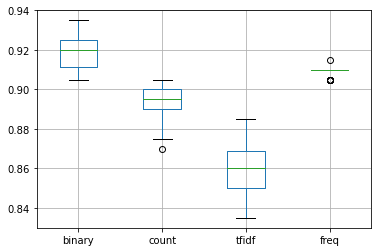

In [10]:
# evaluate a neural network model
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
	scores = list()
	n_repeats = 30
	n_words = Xtest.shape[1]
	for i in range(n_repeats):
		# define network
		model = Sequential()
		model.add(Dense(50, input_shape=(n_words,), activation='relu'))
		model.add(Dense(1, activation='sigmoid'))
		# compile network
		model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
		# fit network
		model.fit(Xtrain, ytrain, epochs=50, verbose=2)
		# evaluate
		loss, acc = model.evaluate(Xtest, ytest, verbose=0)
		scores.append(acc)
		print('%d accuracy: %s' % ((i+1), acc))
        
	return scores

# prepare bag of words encoding of docs
def prepare_data(train_docs, test_docs, mode):
	# create the tokenizer
	tokenizer = Tokenizer()
	# fit the tokenizer on the documents
	tokenizer.fit_on_texts(train_docs)
	# encode training data set
	Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
	# encode training data set
	Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    
	return Xtrain, Xtest

modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()

for mode in modes:
	# prepare data for mode
	Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
	# evaluate model on data for mode
	results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)
    
# summarize results
print(results.describe())
# plot results
results.boxplot()
plt.show()

**Run Sentiment Analysis**

In [7]:
# classify a review as negative (0) or positive (1)
def predict_sentiment(review, vocab, tokenizer, model):
	# clean
	tokens = clean_doc(review)
	# filter by vocab
	tokens = [w for w in tokens if w in vocab]
	# convert to line
	line = ' '.join(tokens)
	# encode
	encoded = tokenizer.texts_to_matrix([line], mode='freq')
	# prediction
	yhat = model.predict(encoded, verbose=0)
    
	return yhat[0,0]

In [8]:
def get_url(movie, year):
    movie = movie.strip()
    movie = movie.replace("-", "_")
    movie = re.sub(r'[^\w\s]', '', movie)
    movie = movie.replace(" ", "_")

    url = 'https://www.rottentomatoes.com/m/' + movie + "_" + year + '/reviews?type=top_critics' 
    response = requests.get(url)
    
    if not response.ok:
        url = 'https://www.rottentomatoes.com/m/' + movie + '/reviews?type=top_critics'
    
    return url


movie = input("Enter the movie name: ")
year = input("Enter the year the movie was released: ")

url = get_url(movie, year)
reviews = get_reviews(url)
mean_score = 0
count = 0
score = []

for index, row in reviews.iterrows():
    score.append(predict_sentiment(row["content"], vocab, tokenizer, model))
    mean_score = mean_score + predict_sentiment(row["content"], vocab, tokenizer, model)
    count = count + 1

mean_score = mean_score / count

final = reviews[["content"]].copy()
final['score'] = score

pd.options.display.float_format = '{:20,.5f}'.format
pd.set_option('display.max_colwidth', None)

print(final)
print("\nAverage rating of", movie, ": ", mean_score)

Enter the movie name: interstellar
Enter the year the movie was released: 2014
                                                                                                                                                                                                                                                            content  \
0                                                                                                                                                                                          Staggeringly beautiful, bafflingly complex, this is proper event cinema.   
1                                                               With all the rampant think pieces questioning the probability of every science fiction film that comes out, it's comforting to across a movie that doesn't really claim to have any of the answers.   
2                                                                                                                                   

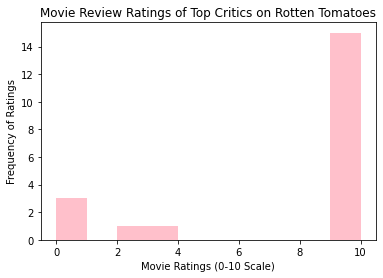

                   name                                     source  score  \
0             Wendy Ide                                 Times (UK)   None   
1     Candice Frederick                           Reel Talk Online     B-   
2          Dwight Brown  National Newspaper Publishers Association   None   
3          Jason Bailey                                 Flavorwire   None   
4        Richard Roeper                          Chicago Sun-Times    4/4   
5           Scott Marks                           San Diego Reader    1/5   
6        David Stratton                  At the Movies (Australia)  4.5/5   
7           Adam Graham                               Detroit News      C   
8      Geoffrey O'Brien                      Film Comment Magazine   None   
9             Ben Sachs                             Chicago Reader    2/4   
10      Jonathan Romney                      Film Comment Magazine   None   
11       Christy Lemire                          ChristyLemire.com    2/4   

In [9]:
score = [i * 10 for i in score]

plt.hist(score, bins = 10, color = 'pink')

plt.xlabel("Movie Ratings (0-10 Scale)")
plt.ylabel("Frequency of Ratings")
plt.title("Movie Review Ratings of Top Critics on Rotten Tomatoes")
plt.show()

reviews_info = reviews.drop('content', axis=1)
print(reviews_info)